# Import Dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')
import keras
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Define Types

In [2]:
from typing import Tuple
ImageShape = Tuple[int, int]
GrayScaleImageShape = Tuple[int, int, int]

# MNIST Sandbox Baseline Example

In [3]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [4]:
from typing import Tuple
import numpy as np
Dataset = Tuple[np.ndarray, np.ndarray]

#download mnist data and split into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(f"The shape of X_train is {X_train.shape}")
print(f"The shape of y_train is {y_train.shape}")
print(f"The shape of X_test is {X_test.shape}")
print(f"The shape of y_test is {y_test.shape} - some example targets: {y_test[:5]}")
mnist_image_shape: ImageShape = X_train.shape[1:]
print(mnist_image_shape)

The shape of X_train is (60000, 28, 28)
The shape of y_train is (60000,)
The shape of X_test is (10000, 28, 28)
The shape of y_test is (10000,) - some example targets: [7 2 1 0 4]
(28, 28)


In [5]:
from keras.utils import to_categorical

OneHotEncodedTarget = np.ndarray
Categories = int
encoded_y_train: OneHotEncodedTarget = to_categorical(y_train)
encoded_y_test: OneHotEncodedTarget = to_categorical(y_test)
print(f"One-hot encoding y_train {y_train.shape} -> {encoded_y_train.shape}")
print(f"One-hot encoding y_test {y_test.shape} -> {encoded_y_test.shape}")

K: Categories = encoded_y_test.shape[1]

One-hot encoding y_train (60000,) -> (60000, 10)
One-hot encoding y_test (10000,) -> (10000, 10)


# Vanilla CNN Implementation

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Input
from tensorflow.python.framework.ops import Tensor
import warnings
warnings.filterwarnings('ignore')

# define model architecture and hyperparameters
NUM_FILTERS_L1 = 64
NUM_FILTERS_L2 = 32
KERNEL_SIZE = 3

# the images are 28 x 28 (pixel size) x 1 (grayscale - if RGB, then 3)
input_dims: GrayScaleImageShape = (28,28,1)

def build_vanilla_cnn(filters_layer1:int, filters_layer2:int, kernel_size:int, input_dims: GrayScaleImageShape)-> Model:
    inputs: Tensor = Input(shape=input_dims)
    x: Tensor = Conv2D(filters=filters_layer1, kernel_size=kernel_size, activation='relu')(inputs)
    x: Tensor = Conv2D(filters=filters_layer2, kernel_size=kernel_size, activation='relu')(x)
    x: Tensor = Flatten()(x)
    predictions = Dense(K, activation="softmax")(x)
    print(predictions)

    #compile model using accuracy to measure model performance
    model: Model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    return model

model: Model = build_vanilla_cnn(NUM_FILTERS_L1, NUM_FILTERS_L2, KERNEL_SIZE, input_dims)

Tensor("dense_3/Softmax:0", shape=(?, 10), dtype=float32)


In [6]:
X_train.reshape((60000,1,28,28))

def expand_tensor_shape(X_train: np.ndarray)-> np.ndarray:
    new_shape: Tuple = X_train.shape + (1,)
        
#     new_tensor = X_train.reshape(new_shape).reshape((-1,1,28,28))
    new_tensor = X_train.reshape(new_shape)
    print(f"Expanding shape from {X_train.shape} to {new_tensor.shape}")
    return new_tensor

X_train_expanded: np.ndarray = expand_tensor_shape(X_train)
X_test_expanded: np.ndarray = expand_tensor_shape(X_test)
    
    
# train model and retrieve history
# from keras.callbacks import History
# history: History = model.fit(X_train_expanded, encoded_y_train, 
#                              validation_data=(X_test_expanded, encoded_y_test), epochs=2, batch_size=2058)

Expanding shape from (60000, 28, 28) to (60000, 28, 28, 1)
Expanding shape from (10000, 28, 28) to (10000, 28, 28, 1)


## Global Average Pooling Layer

Output shape of convolutional layer is typically `batch size x number of filters x width x height`. The GAP layer will take the average of the width/height axis

In [8]:
from keras import backend as K

In [9]:
np.reshape(X_train_expanded, (-1,1,28,28)).shape

(60000, 1, 28, 28)

In [10]:
from keras.layers import Dense, Conv2D, Flatten, Input, MaxPool2D

In [48]:
###### from keras.layers import Layer, Lambda, Input
from tensorflow.python.framework.ops import Tensor
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Input, MaxPool2D
from tensorflow.python.framework.ops import Tensor
def global_average_pooling(x: Layer):
    return K.mean(x, axis = (2,3))

def global_average_pooling_shape(input_shape):
    # return the dimensions corresponding with batch size and number of filters
    return (input_shape[0], input_shape[-1])

def build_global_average_pooling_layer(function, output_shape):
    return Lambda(pooling_function, output_shape)

inputs: Tensor = Input(shape=(28,28,1))
x: Tensor = Conv2D(filters=32, kernel_size=5, activation='relu')(inputs)
# x: Tensor = MaxPool2D()(x)
# x: Tensor = Conv2D(filters=64, kernel_size=5, activation='relu')(x)
x: Tensor = Lambda(lambda x: K.mean(x, axis=(1,2)), output_shape=global_average_pooling_shape)(x)
# x: Tensor = Dense(128, activation="relu")(x)
predictions: Tensor = Dense(10, activation="softmax")(x)
model: Model = Model(inputs=inputs, outputs=predictions)
model.summary()
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
from keras.callbacks import History
history: History = model.fit(X_train_expanded, encoded_y_train,  
                             validation_data=(X_test_expanded, encoded_y_test), epochs=100, batch_size=5126)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
lambda_1 (Lambda)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 1,162.0
Trainable params: 1,162.0
Non-trainable params: 0.0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 5s - loss: 6.9768 - acc: 0.0942 - val_loss: 4.3748 - val_acc: 0.0978
Epoch 2/100
60000/60000 [==============================] - 5s - loss: 3.3634 - acc: 0.08

60000/60000 [==============================] - 6s - loss: 0.7758 - acc: 0.7841 - val_loss: 0.7230 - val_acc: 0.8034
Epoch 58/100
60000/60000 [==============================] - 7s - loss: 0.7696 - acc: 0.7849 - val_loss: 0.7161 - val_acc: 0.8054
Epoch 59/100
60000/60000 [==============================] - 6s - loss: 0.7612 - acc: 0.7893 - val_loss: 0.7125 - val_acc: 0.8020
Epoch 60/100
60000/60000 [==============================] - 6s - loss: 0.7543 - acc: 0.7921 - val_loss: 0.7062 - val_acc: 0.8066
Epoch 61/100
60000/60000 [==============================] - 7s - loss: 0.7487 - acc: 0.7917 - val_loss: 0.6959 - val_acc: 0.8111
Epoch 62/100
60000/60000 [==============================] - 7s - loss: 0.7413 - acc: 0.7949 - val_loss: 0.6893 - val_acc: 0.8127
Epoch 63/100
60000/60000 [==============================] - 7s - loss: 0.7340 - acc: 0.7984 - val_loss: 0.6845 - val_acc: 0.8123
Epoch 64/100
60000/60000 [==============================] - 7s - loss: 0.7280 - acc: 0.7985 - val_loss: 0.6766

## Save the Class Activation Model Weights

In [12]:
import cv2

from keras.layers import Layer, Lambda
def global_average_pooling(x: Layer):
    return K.mean(x, axis = (2,3))

def global_average_pooling_shape(input_shape):
    # return only the first two dimensions (batch size and number of filters)
    return input_shape[0:2]

def build_global_average_pooling_layer(function, output_shape):
    return Lambda(pooling_function, output_shape)


def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

In [49]:
# persist mode

save_filepath: str = "basic_cam.h5"
model.save(save_filepath)

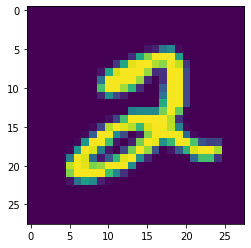

In [86]:
first_image = X_train[5]
first_image = first_image.reshape(28,28,1)
img = np.array(first_image).reshape(1, 28, 28, 1)
img.shape
plt.imshow(img.reshape((28,28)))
#img = np.array([np.transpose(np.float32(first_image), (2, 0, 1))])

In [15]:
from keras.models import load_model

model = load_model("basic_cam.h5")

In [3]:
dense_10_layer: Layer = model.layers[-1]
dense_10_weights = dense_10_layer.get_weights()[0]
print(f"Dense 10 weights: {dense_10_weights.shape}")
dense_128_layer: Layer = model.layers[-2]
dense_128_weights = dense_128_layer.get_weights()[0]
print(f"Dense 128 weights: {dense_128_weights.shape}")

NameError: name 'Layer' is not defined

(24, 24, 32)
(32, 10)


Text(0.5, 1.0, 'True Image')

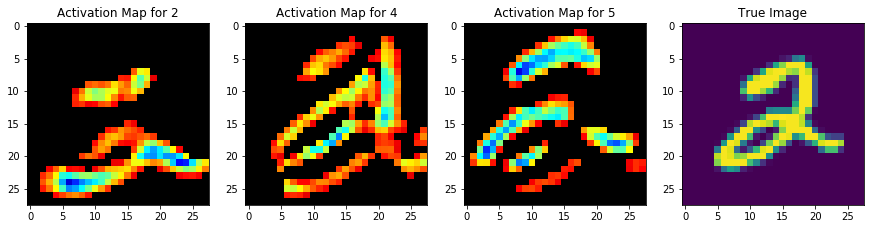

In [112]:
import keras.backend as K
class_weights = model.layers[-1].get_weights()[0]
final_conv_layer = get_output_layer(model, "conv2d_1")

get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
[conv_outputs, predictions] = get_output([img])
conv_outputs = conv_outputs[0,:,:,:]
print(conv_outputs.shape)
print(class_weights.shape)

def make_cam(conv_outputs, class_weights, original_shape, target_class):
    cam = np.zeros(dtype=np.float32, shape = conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, target_class]):
        cam += w * conv_outputs[:,:,i]
    cam /= np.max(cam)
    return cv2.resize(cam, (28, 28))

def make_heatmap(cam):
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam < 0.1)] = 0
    return heatmap


cam = make_cam(conv_outputs, class_weights, original_shape=(28,28), target_class=2)
false_cam = make_cam(conv_outputs, class_weights, original_shape=(28,28), target_class=4)
false2_cam = make_cam(conv_outputs, class_weights, original_shape=(28,28), target_class=5)

heatmap = make_heatmap(cam)
false_heatmap = make_heatmap(false_cam)
false2_heatmap = make_heatmap(false2_cam)

new_img = heatmap*0.5 + img
final_img = new_img.reshape((28,28,3))

# f, axarr = plt.subplots(2,1)
# axarr[0,0].imshow(heatmap)
# axarr[0,1].imshow(img.reshape(28,28))

imgs = [heatmap, img.reshape(28,28)]
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
axes[0].imshow(heatmap)
axes[0].set_title("Activation Map for 2")
axes[1].imshow(false_heatmap)
axes[1].set_title("Activation Map for 4")
axes[2].imshow(false2_heatmap)
axes[2].set_title("Activation Map for 5")
axes[3].imshow(img.reshape((28,28)))
axes[3].set_title("True Image")

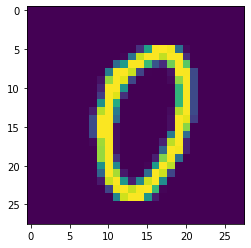

In [28]:
import matplotlib.pyplot as plt
plt.imshow(img.reshape((28,28)))

In [23]:
cam /= np.max(cam)

(24, 24)

In [47]:
import keras.backend as K
from tensorflow.python.framework.ops import Tensor

dense_weights = model.layers[-2].get_weights()[0]

softmax_weights = model.layers[-1].get_weights()[0]

dense_weights.shape
softmax_weights.shape

final_conv_layer = get_output_layer(model, "conv2d_28")
final_conv_layer.output

<tf.Tensor 'conv2d_28_1/Relu:0' shape=(?, 8, 8, 64) dtype=float32>

In [18]:
import keras.backend as K
from tensorflow.python.framework.ops import Tensor
class_weights: np.ndarray = model.layers[-1].get_weights()[0] # class weights is of shape 32 x 10 (number of filter outputs x classes)
print(f"Class weights is shape {class_weights.shape}")
final_conv_layer: Conv2D = get_output_layer(model, "conv2d_28")

input_tensor: Tensor = model.layers[0].input
final_conv_layer_output: Tensor = final_conv_layer.output
model_class_weights: Tensor = model.layers[-1].output
    
# K.function is a function factory that accepts arbitrary input layers and outputs arbitrary output layers
get_output = K.function([input_tensor], [final_conv_layer_output, model_class_weights])

[conv_outputs, predictions] = get_output([img])
print("Conv2D output shape:", conv_outputs.shape) # should match the shape of the outputs from the Conv2D layer
print("Predictions:", predictions.shape)
np.argmax(predictions)

conv_outputs = conv_outputs[0,:,:,:]
# [conv_outputs, predictions] = get_output([img])
# conv_outputs = conv_outputs[0, :, :, :]

Class weights is shape (128, 10)
Conv2D output shape: (1, 8, 8, 64)
Predictions: (1, 10)


In [22]:
class_weights.shape

(128, 10)

In [40]:
# Create the class activation map

class_activation_map = np.zeros(dtype=np.float32, shape=conv_outputs.shape[1:3])
class_activation_map.shape

(8, 64)

In [25]:
target_class = 0

for i,w in enumerate(class_weights[:, target_class]):
    print(conv_outputs[i,:,:].shape)

(8, 64)
(8, 64)
(8, 64)
(8, 64)
(8, 64)
(8, 64)
(8, 64)
(8, 64)


IndexError: index 8 is out of bounds for axis 0 with size 8

In [ ]:


for i, w in enumerate(class_weights[:, target_class]):
    print(w, "w")
    print(conv_outputs[i,:,:].shape, "conv_output")
    print(class_activation_map)
    input()
    class_activation_map += w * conv_outputs[i,:,:]

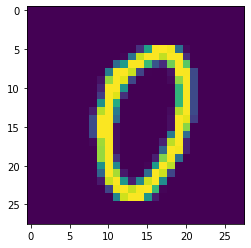

In [105]:
plt.imshow(first_image.reshape((28,28)))

In [ ]:
        #Reshape to the network input shape (3, w, h).
        img = np.array([np.transpose(np.float32(original_img), (2, 0, 1))])
        
        #Get the 512 input weights to the softmax.
        class_weights = model.layers[-1].get_weights()[0]
        final_conv_layer = get_output_layer(model, "conv5_3")
        get_output = K.function([model.layers[0].input], \
                    [final_conv_layer.output, 
        model.layers[-1].output])
        [conv_outputs, predictions] = get_output([img])
        conv_outputs = conv_outputs[0, :, :, :]

        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
        target_class = 1
        for i, w in enumerate(class_weights[:, target_class]):
                cam += w * conv_outputs[i, :, :]

In [78]:
image_path = 
original_img = cv2.imread(image_path, 1)
width, height, _ = original_image.shape

In [24]:


def build_vanilla_cnn(filters_layer1:int, filters_layer2:int, kernel_size:int, input_dims: GrayScaleImageShape)-> Model:
    inputs: Tensor = Input(shape=input_dims)
    x: Tensor = Conv2D(filters=filters_layer1, kernel_size=kernel_size, activation='relu')(inputs)
    x: Tensor = Conv2D(filters=filters_layer2, kernel_size=kernel_size, activation='relu')(x)
    x: Tensor = build_global_average_pooling_layer(global_average_pooling, )
    predictions = Dense(K, activation="softmax")(x)
    print(predictions)

    #compile model using accuracy to measure model performance
    model: Model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    return model

# Example Attention Model

In [11]:
inputs = Input(shape=input_dims)

In [134]:
from keras.layers import merge

def build_model(input_dim):
    inputs = Input(shape=input_dim)

    # ATTENTION PART STARTS HERE
    attention_probs = Dense(input_dim, activation='softmax', name='attention_vec')(inputs)
    attention_mul = merge([inputs, attention_probs], output_shape=32, name='attention_mul', mode='mul')
    # ATTENTION PART FINISHES HERE

    attention_mul = Dense(64)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model

inputs = Input(shape=input_dims)
attention_probs = Dense(input_dims, activation='softmax', name='attention_vec')(inputs)

TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

## Compile and Fit Model

In [121]:
X_train.reshape((60000,1,28,28))

def expand_tensor_shape(X_train: np.ndarray)-> np.ndarray:
    new_shape: Tuple = X_train.shape + (1,)
    print(f"Expanding shape from {X_train.shape} to {new_shape}")
    return X_train.reshape(new_shape)

X_train_expanded: np.ndarray = expand_tensor_shape(X_train)
X_test_expanded: np.ndarray = expand_tensor_shape(X_test)

Expanding shape from (60000, 28, 28) to (60000, 28, 28, 1)
Expanding shape from (10000, 28, 28) to (10000, 28, 28, 1)


# FEI Face Dataset

In [12]:
from PIL.JpegImagePlugin import JpegImageFile

image: JpegImageFile = load_img('1-01.jpg')

PIL.JpegImagePlugin.JpegImageFile